# Multimodal Variational Autoencoders

![image.png](image.png)

In this practical session, we will see:

- How to define and train a Multimodal Variational Autoencoder model using MultiVae
- Which metrics can be used to evaluate and compare Multimodal Variational Autoencoders.
- How to perform multimodal data augmentation using these models and different sampling methods

**Throughout the session, you can look for help in the documentation of the library** [here](https://multivae.readthedocs.io)



In [7]:
# First install multivae 
# !pip install multivae
# !pip install torch

# 1. Define and train a multimodal autoencoder

First, we will import a toy dataset called PolyMNIST which contains 5 image modalities. 

In [ ]:
# Load a the PolyMNIST dataset which contains 5 modalities
from multivae.data.datasets import MMNISTDataset
from torch.utils.data import random_split

data_path = '/Users/agathe/dev/data'
train_dataset= MMNISTDataset(data_path=data_path,
                             split='train',
                             download=False,
                             missing_ratio=0 # Here we use the complete dataset but it is possible to train with incomplete datasets
                             )

# Split the dataset into a train dataset and a validation set
train_dataset, val_dataset = random_split(train_dataset, [0.9,0.1])

# Let's look at the first sample of this dataset
small_batch = train_dataset[0]
print("You can access the data and labels of a multimodal sample as follows:")
print("samples.data and samples.labels")

# samples.data is a dictionary containing the five modalities
print(f"This dataset contains 5 modalities with names: {small_batch.data.keys()}")

# Each modality is a tensor
print(f"The shape for modality m0 is {small_batch.data['m0'].shape}") # 


You can access the data and labels of a multimodal sample as follows:
samples.data and samples.labels
This dataset contains 5 modalities with names: dict_keys(['m0', 'm1', 'm2', 'm3', 'm4'])
The shape for modality m0 is torch.Size([3, 28, 28])


Let's visualize the images contained in this dataset. 

Each line corresponds to a sample, and each column corresponds to a modality.


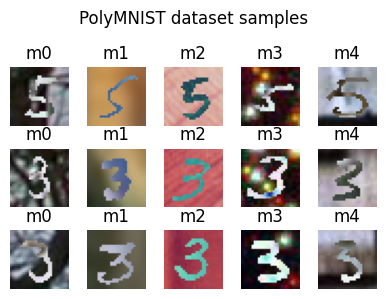

In [9]:
import torch
import matplotlib.pyplot as plt

# For the first 3 samples, we plot the images contained in each modality
fig, ax = plt.subplots(3,5, figsize=(4,3))

# Iterate on the datapoints
for i_sample in range(3):
    
    # TODO: get the sample with index i_sample from train_dataset
    small_batch = train_dataset[i_sample] # TODO
    
    # For each of the five modalities, display the image
    for m, modality_name in enumerate(['m0','m1','m2','m3','m4']):
        
        # TODO: get the modality tensor
        sample_modality = small_batch.data[modality_name] # TODO
                
        # Transform it into an image we can display
        ndarr = sample_modality.mul(255).clamp_(0,255).int().permute(1,2,0).numpy()
        
        # Use the 'imshow' method to display the images
        ax[i_sample,m].imshow(ndarr)
        ax[i_sample,m].set_title(f'{modality_name}')
        ax[i_sample, m].set_axis_off()
  
print("Each line corresponds to a sample, and each column corresponds to a modality.")
plt.suptitle('PolyMNIST dataset samples')
plt.tight_layout()
        


Each multimodal sample in PolyMNIST is composed of five images, each containing a number. The backgrounds depend on the modality but the label of the
digit is the same in all modalities. 

Now we will design a Multimodal Vae model for this dataset. 
We will use the [MVTCAE](https://multivae.readthedocs.io/en/latest/models/multimodal_vaes/mvtcae.html) model that is easy to train and works pretty well on this dataset.

In [10]:
# First we import the model class and config from multivae
from multivae.models import MVTCAE, MVTCAEConfig

# TODO: Complete the model configuration.
# (help) https://multivae.readthedocs.io/en/latest/models/multimodal_vaes/mvtcae.html#multivae.models.MVTCAEConfig
# you can choose the latent dimension of your choice.

model_config = MVTCAEConfig( # TODO
    n_modalities=5,
    latent_dim=64,
    input_dims={f'm{i}':(3,28,28) for i in range(5)},
    decoders_dist={f'm{i}': 'normal' for i in range(5)}, # what is the output distribution for the decoder ? (normal distribution corresponds to a Mean Squared Error Loss)
    beta= 2.5 # how strong is the regularization on the latent space
)

print(f"My model has a latent dimension of {model_config.latent_dim}")

My model has a latent dimension of 64


Then, we should define an encoder and a decoder architectures for each modality. 

Each encoder is a neural network that takes the modality data $X_m$ as input and returns $\mu(X_m)$ and $\Sigma(X_m)$ for sampling a latent code $q_{\phi(z|X_m)} = \mathcal{N}(\mu(X_m),\Sigma(X_m))$. 

Each decoder is a neural network that takes the latent code $z$ as input and returns the reconstructed modality data $\hat{X_m}$.

Here we import simple convolution architectures from the library but you can define your own if you want to. 
It only needs to inherits from the BaseEncoder/BaseDecoder classes. 



In [ ]:
from multivae.models.nn.mmnist import EncoderConvMMNIST, DecoderConvMMNIST

# We define a dictionary with a convolutional encoder for each modality
encoders = {
    'm0' : EncoderConvMMNIST(model_config, bias=False),
    'm1' : EncoderConvMMNIST(model_config, bias=False),
    'm2' : EncoderConvMMNIST(model_config, bias=False),
    'm3' : EncoderConvMMNIST(model_config, bias=False),
    'm4' : EncoderConvMMNIST(model_config, bias=False)
}

# We define a dictionary with a convolutional decoder for each modality
decoders = {
    'm0' : DecoderConvMMNIST(model_config),
    'm1' : DecoderConvMMNIST(model_config),
    'm2' : DecoderConvMMNIST(model_config),
    'm3' : DecoderConvMMNIST(model_config),
    'm4' : DecoderConvMMNIST(model_config)
}

print(encoders['m0'])

EncoderConvMMNIST(
  (shared_encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2048, out_features=64, bias=True)
    (8): ReLU()
  )
  (class_mu): Linear(in_features=64, out_features=64, bias=False)
  (class_logvar): Linear(in_features=64, out_features=64, bias=False)
)


Now we have everything we need to define and train the model.

In [19]:
from multivae.models import MVTCAE

# TODO: instantiate the model with the model_config, encoders and decoders
model = MVTCAE( # TODO 
    model_config=model_config,
    encoders=encoders,
    decoders=decoders
)

# We use a trainer from the library
from multivae.trainers import BaseTrainer, BaseTrainerConfig

# TODO: instantiate a BaseTrainerConfig with num_epochs=10
# (hint): you see the documentation here if you need help: https://multivae.readthedocs.io/en/latest/trainers/base.html#multivae.trainers.BaseTrainerConfig
trainer_config = BaseTrainerConfig( 
    num_epochs=2,
    learning_rate=1e-3,
    steps_predict=5, # to visualize the reconstructions during training
)

# TODO: instantiate the trainer and start training  
trainer = BaseTrainer(model=model, # TODO
                      train_dataset=train_dataset,
                      eval_dataset=val_dataset,
                      training_config=trainer_config)

trainer.train()

Model passed sanity check !
Ready for training.

Setting the optimizer with learning rate 0.001
Created dummy_output_dir/MVTCAE_training_2025-06-20_12-20-04. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 2
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !




















































New best model on eval saved!
Eval of epoch 1/2: 100%|██████████| 94/94 [00:10<00:00,  9.38batch/s]
--------------------------------------------------------------------------
Train loss: 10892.5107
Eval loss: 10882.1574
--------------------------------------------------------------------------
Training o

KeyboardInterrupt: 

After training, you could easily reload the trained model from the checkpoint folder using the following code:
```
from multivae.models import AutoModel
trained_model = AutoModel.load_from_folder('path_to_checkpoint')
````

But in the rest of the tutorial, we will load fully trained models from Hugging Face Hub to avoid waiting for the model to train.

## Evaluating a trained model

In this section, we reload fully trained models from Hugging Face Hub and see how well they perform on different tasks. 

We will look at different metrics:
 - **Reconstruction** : good reconstruction means that we have learned efficient latent representations
 - **Cross-Modal Generation** : Is our model good at generating missing modalities ? 
 - **(Bonus) Clustering Metrics**: Is the multimodal latent representation useful for clustering ? 

In [46]:
# Load a trained model

# TODO: offer different options here.

### Reconstruction
One thing we want to evaluate is the quality of the reconstruction. 

If we take a multimodal sample $X$, encode it to obtain a latent code $z$ and decode this $z$, we should obtain a reconstructed sample $\hat{X}$ that is close to our original data. Good reconstructions mean that we have learned efficient latent embeddings $z$. 

Below, we first visualize some reconstructions, then we compute average Mean Squared Error for all the reconstructions in the validation set. 

In [14]:
## Firt we compute the reconstructions for two examples datapoints

# Take 5 samples from the validation set
small_batch = val_dataset[:5]

# TODO: Using the 'encode' function of the model, compute the latent embeddings 
# (help) : https://multivae.readthedocs.io/en/latest/models/multimodal_vaes/base.html#multivae.models.BaseMultiVAE.encode

embeddings = model.encode(small_batch) # TODO
print(f"Latent codes have shape {embeddings.z.shape}")

# TODO: Using the 'decode' function of the model, compute the reconstructions
# (help) : https://multivae.readthedocs.io/en/latest/models/multimodal_vaes/base.html#multivae.models.BaseMultiVAE.encode
reconstructions = model.decode(embeddings) # TODO

print("Reconstructions are a dictionary with the reconstructed tensor for each modality.")
print(f"The reconstruction for modality m0 has shape {reconstructions['m0'].shape}")

Latent codes have shape torch.Size([5, 64])
Reconstructions are a dictionary with the reconstructed tensor for each modality.
The reconstruction for modality m0 has shape torch.Size([5, 3, 28, 28])


Text(0.5, 0.98, 'Reconstructions')

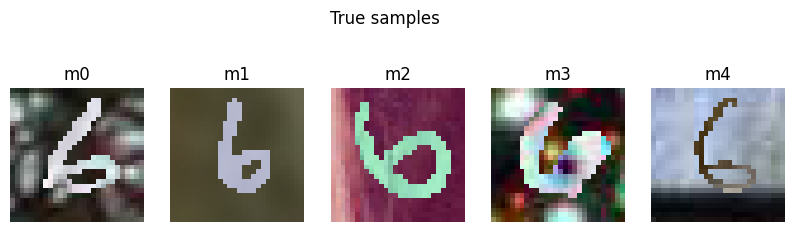

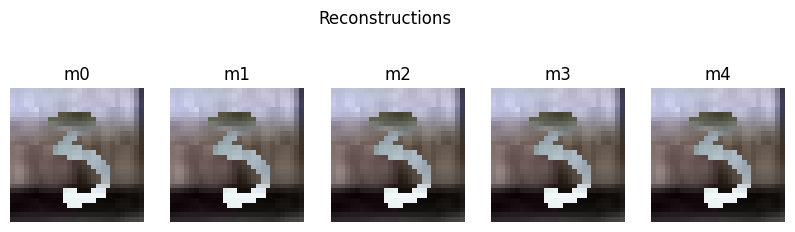

In [18]:
## TODO: plot the original images for the first sample and the reconstructed images

# Plot each modality image for the first sample 
fig, ax = plt.subplots(1, 5, figsize=(10, 3))
for m, modality_name in enumerate(['m0','m1','m2','m3','m4']):
    
    # TODO: Get the modality tensor from small_batch.data
    batch_modality = small_batch.data[modality_name]
    
    # TODO: get only the first sample
    first_sample_modality = batch_modality[0]
        
    # Transform it into an image we can display
    ndarr = (
        first_sample_modality.mul(255).add_(0.5) 
        .clamp_(0, 255)
        .permute(1, 2, 0)
        .to("cpu", torch.uint8)
        .numpy()
    )
    
    # Use the imshow methos to display the images
    ax[m].imshow(ndarr)
    ax[m].set_title(f'{modality_name}')
    ax[m].set_axis_off()
    
plt.suptitle('True samples')

# Plot each modality for the first sample reconstruction
fig, ax = plt.subplots(1, 5, figsize=(10, 3))
for m, modality_name in enumerate(['m0','m1','m2','m3','m4']):
    
    # TODO: Get the modality tensor from the reconstructions dictionary
    reconstructions_modality = reconstructions[modality_name]
    
    # TODO: get only the first sample
    first_sample_reconstruction = reconstructions_modality[0]
    
    # Transform it into an image we can display
    ndarr = (
        sample_modality.mul(255).add_(0.5) 
        .clamp_(0, 255)
        .permute(1, 2, 0)
        .to("cpu", torch.uint8)
        .numpy()
    )
    
    # Use the imshow methos to display the images
    ax[m].imshow(ndarr)
    ax[m].set_title(f'{modality_name}')
    ax[m].set_axis_off()

plt.suptitle('Reconstructions')

*Remark*: In multivae, there is a method to plot reconstructions quicker: the *Visualization* class helps to evaluate the quality of produced images. 

Reconstructions in the first modality


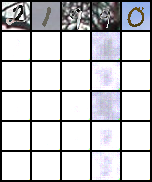

In [56]:
from multivae.metrics import Visualization

visualisation_module = Visualization(model,val_dataset)

print("Reconstructions in the first modality")
visualisation_module.reconstruction('m0')

To evaluate **quantitatively** the reconstructions, we can compute the [MeanSquaredError](https://en.wikipedia.org/wiki/Mean_squared_error) between the original images and their reconstructions: 

$$MSE(x,\hat{x}) = \frac{1}{N_{pixels}}\sum (x_i - \hat{x}_i)^2$$

In practice, we can compute it by using the [Reconstruction metric](https://multivae.readthedocs.io/en/latest/metrics/reconstruction.html) module. 

In [59]:
from multivae.metrics import Reconstruction, ReconstructionConfig

print("Let's compute the Mean Squared Error on the entire validation dataset!")

reconstruction_metric_config = ReconstructionConfig( # TODO
    batch_size=64, # We use a batch size of 64 to compute the metric
    metric='MSE' # We set here that the metric we want to evaluate is MSE. You can also evaluate SSIM.
)

# TODO: instantiate the Reconstruction module and call eval() to compute the MSE
# (help): https://multivae.readthedocs.io/en/latest/metrics/reconstruction.html

reconstruction_metric = Reconstruction( # TODO
    model,
    val_dataset,
    eval_config=ReconstructionConfig(batch_size=64,metric='MSE') # We set here that the metric we want to evaluate is MSE. You can also evaluate SSIM.
)

# Compute the joint reconstruction metric and unimodal reconstructions metrics
mean_squared_errors = reconstruction_metric.eval()

Subset ['m0', 'm1', 'm2', 'm3', 'm4'] reconstruction : 125.28738403320312 
Subset ['m0'] reconstruction : 2780.720947265625 
Subset ['m1'] reconstruction : 1336.282958984375 
Subset ['m2'] reconstruction : 1984.1163330078125 
Subset ['m3'] reconstruction : 380.4729919433594 
Subset ['m4'] reconstruction : 1765.8270263671875 


### Generating missing modalities
Now we want to see if our model is able to generate missing modalities given a set of observed modalities.

Recall that for generating missing modalities, we have to generate a latent $z$ using the encoders from observed modalities and then decode this $z$ to generate
the missing modality. 

To quickly get a look at the model's performance for this task, we can use the [Visualization](https://multivae.readthedocs.io/en/latest/metrics/visualization.html) module again. 

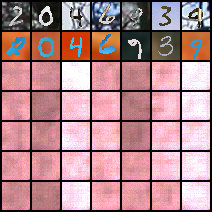

In [60]:
from multivae.metrics import Visualization, VisualizationConfig

# TODO: instantiate the Visualization module with our model and val_dataset as test_dataset
# (help): you can use the conditional_from_subset method and use the documentation : https://multivae.readthedocs.io/en/latest/metrics/visualization.html

vis_module = Visualization( # TODO
    model=model,
    test_dataset=val_dataset,
    eval_config=VisualizationConfig(n_data_cond=7,n_samples=5) 
    # we will look at 7 samples from the dataset and generate 5 artificial samples in the missing modalities
)

print("Generations in modality 'm2' from observed modalities 'm0', 'm1'.")
# TODO : generate the modality 'm2' from modalities 'm0','m1'
# (hint): you can use the conditional_from_subset method and use the documentation : https://multivae.readthedocs.io/en/latest/metrics/visualization.html
vis_module.conditional_samples_subset( # TODO.
    subset=['m0', 'm1'], # observed modalities
    gen_mod='m2' # the modality we generate from the observed ones
)

*Question*: how do the generated samples look ? 

To have a quantitative evaluation of this conditional generations, there are two metrics we can use:
1. The *coherence* of the generations: with pretrained classifiers, we check if the generated modalities correspond to the same labels as the observed modalities. 

2. The *diversity* of the generation: we compare the Fréchet Inception Distance between synthetic and real images. This metric is a proxy to evaluate the diversity and similarity between two sets of images. 

Both those metrics are implemented in the multivae.metrics module.
TODO: use the CoherenceEvaluator module to compute the coherence of the generations.


In [99]:
import os
from multivae.metrics import CoherenceEvaluator, CoherenceEvaluatorConfig, FIDEvaluator, FIDEvaluatorConfig

# First we need to load the classifiers for evaluating coherence
from multivae.metrics.classifiers.mmnist import load_mmnist_classifiers

classifiers_path = os.path.join(data_path,'clf')
classifiers = load_mmnist_classifiers(classifiers_path)

## TODO: use the CoherenceEvaluator module to compute the coherence of the model
# First instantiate a CoherenceEvaluator module
coherence_module = CoherenceEvaluator(
    model=model,
    classifiers=classifiers,
    test_dataset=val_dataset
)

# TODO: evaluate the coherence of the model when generating samples from modalities [m0,m1] to other modalities
# (hint): you can use the coherence_from_subset method and the documentation: 
output= coherence_module.coherence_from_subset(['m0', 'm1']) # you can change the subset

Subset ['m0', 'm1'] accuracies 
{'m0_m1_to_m2': tensor(0.0998), 'm0_m1_to_m3': tensor(0.0980), 'm0_m1_to_m4': tensor(0.1000)}
Mean subset ['m0', 'm1'] accuracies : 0.0992805


TODO: 
We would expect that the more observed modalities we have, the more coherent are the generation. 
Is it indeed the case for this model ? 
Can you plot the evolution of the coherence given additional modalities ? 

In [73]:
observed_modalities = [['m0'], ['m0','m1'],['m0','m1','m2'],['m0','m1','m2','m3']]
mean_coherences = []

# to do : compute the mean coherences for each of observed subset and plot the curve

In addition to the coherence, we can compute the FID of the generations. 

In [102]:
from multivae.metrics import FIDEvaluator, FIDEvaluatorConfig

# Load FID weights
fid_path = '/Users/agathe/dev/data/fid/pt_inception-2015-12-05-6726825d.pth'

# Instantiate a FIDEvaluator module
fid_module = FIDEvaluator(model,val_dataset,eval_config=FIDEvaluatorConfig(inception_weights_path=fid_path))

# TODO: Compute the FID when generating the m2 modality from [m0,m1]
# (hint): you can use the compute_fid_from_conditional_generation method
print('Computing FID. This could take a while.')
fid_module.compute_fid_from_conditional_generation(['m0','m1'], gen_mod='m2')

/Users/agathe/dev/multivae_package/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/agathe/dev/multivae_package/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/agathe/dev/multivae_package/venv/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
 33%|███▎      | 4/12 [06:15<12:30, 93.76s/it]


KeyboardInterrupt: 

You can run this evaluation section with the other pretrained models to see how they compare. 
At the end of this notebook, you can also evaluate the pertinence of the models for clustering tasks. 

## Data Augmentation: generating fully synthetic multimodal samples

In the section above, we used multimodal VAEs to generate missing modalities from observed ones. 
But these models could also be used to generate **fully synthetic multimodal samples**. 
These technique could be used to *augment* a small size dataset as done in ... ref to improve performance on a downstream task such as classification, segmentation etc...

The most natural way to generate full synthetic samples is to first sample a latent code from the prior distribution
$$z \sim p(z) = \mathcal{N}(0,I)$$
and then decode this $z$ in each modality. 

We first look at the results we obtain with this method and then consider more advanced methods. 

The shape of the generations in m0 modality is torch.Size([5, 3, 28, 28])


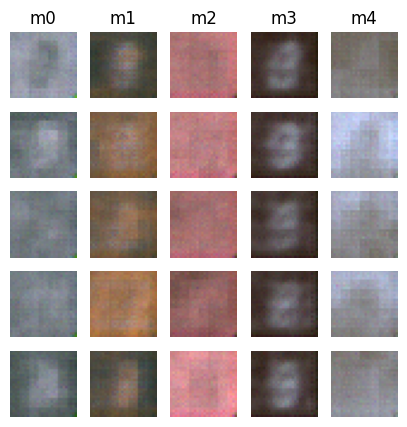

In [109]:
# Generate latent codes from the prior. 
n_samples = 5 
latent_codes = model.generate_from_prior(n_samples) 

# TODO: Decode these samples to generate multimodal images
generations = model.decode(latent_codes) 
print(f"The shape of the generations in m0 modality is {generations['m0'].shape}")

# Plot the generations
fig, ax = plt.subplots(n_samples,5, figsize=(5,5))
for i in range(n_samples):
    for m, modality_name in enumerate(model.modalities_name):
        
        modality_generation = generations[modality_name][i] # TODO
        
        # Transform the image to display it 
        modality_image = modality_generation.mul(255).add_(0.5).clamp_(0,255).int().permute(1,2,0).numpy()
        if i==0:
            ax[i,m].set_title(modality_name)
        ax[i,m].imshow(modality_image)
        ax[i,m].set_axis_off()



As we can see, this method doesn't give very good results because in practice the latent codes $z$ don't exactly follow the prior distribution.
To improve these unconditional generations, we can try to approximate *a posteriori* the distributions of the latent codes.

For instance, we can fit a Gaussian Mixture Model on the embeddings of the training set and sample new latent codes from this distribution. 

(maybe add an image)

For this we can use the [GaussianMixtureSampler](https://multivae.readthedocs.io/en/latest/samplers/gmm.html) from the library.

In [ ]:
from multivae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig

# TODO: Define a GaussianMixtureSampler with 10 components
gmm_config = GaussianMixtureSamplerConfig(n_components=10) # TODO

gmm = GaussianMixtureSampler( # TODO
    model=model,
    sampler_config=gmm_config
)

# We fit the model on the training set
# The GaussianMixtureSampler computes all the embeddings for the training set and then fit a GMM model on them.
gmm.fit(train_dataset)

Once the Gaussian Mixture is fit, we can sample latent codes from it.

In [82]:
# TODO: use the sample method of the gmm to sample 5 latent codes
latent_codes = gmm.sample(n_samples=5)

# Decode these latent codes and plot the generated images


The generations are already much better. 

Note that the Visualization Module and CoherenceEvaluator can also be used with the sampler for fast evaluation. 

Joint coherence with sampler GaussianMixtureSampler: tensor(0.)


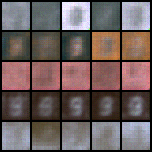

In [113]:
# Compute Coherence of fully synthetic samples generated with our Gaussian Mixture
CoherenceEvaluator(model, classifiers, val_dataset, sampler=gmm).joint_coherence() # pass the sampler as argument
# Visualize a few generated samples
Visualization(model, val_dataset, sampler=gmm).unconditional_samples() # pass the sampler as argument


Here we used a Gaussian Mixture but there are other sampling methods we can use. 

You can replace the GaussianMixtureSampler by one of the following and see the results !

- [MAFSampler](https://multivae.readthedocs.io/en/latest/samplers/maf.html): Fit a masked autoregressive flow to the latent embeddings and sample from it.
- [IAFSampler](https://multivae.readthedocs.io/en/latest/samplers/iaf.html): Fit an inverse autoregressive flow to the latent embeddings and sample from it. 

**Key take-away**: for generating fully synthetic multimodal samples, modelling a posteriori the distribution of the latent codes can be very powerful!


In [ ]:
# TODO: choose another sampler, compute visualizations and coherence of fully synthetic samples

# What's next ?

If you finished super early and you want to do the bonus part, you can look at clustering metrics for your model in the section below. 

- **To know more about the different multimodal VAEs methods** that exists, you can look at this [survey paper](https://arxiv.org/abs/2207.02127). Short descriptions of models are also available in MultiVae's [documentation](https://multivae.readthedocs.io/en/latest/models/multivae.models.html). 

- **Which model should I use in my application ?** : this [benchmark case study](https://github.com/AgatheSenellart/MultiVae/blob/main/examples/case_studies/benchmarking_on_partial_polymnist/results.md) can help you decide. Note that many models can be trained on **incomplete datasets** including the ones used in this tutorial. 

- **What are the medical applications of multimodal VAEs ?** : These models can be used to generate synthetic medical images as done in [(Reuben et al, 2025)](https://arxiv.org/abs/2309.08747), to augment or complete a dataset, or for **anomaly detection** as done in [(Aguila et al 2023)](https://arxiv.org/abs/2303.12706) and [(Kumar et al, 2024)](https://www.biorxiv.org/content/10.1101/2024.12.12.628273v1.full.pdf).

### Bonus part: clustering

In this part, we look more closely at the latent codes and see if we can do easy clustering of the data on them. 
Remember that our data is composed of multimodal images of digits from 0 to 10. Therefore we can see if we retrieve these 10 categories when we perform clustering on the data. 

The module multivae.metrics.Clustering allows easy clustering on the latent embeddings using a K-means algorithm.

TODO: using this module and the documentation of this module, can you perform clustering on the latent embeddings and return the K-means accuracy of the model ? 

In [90]:
from multivae.metrics import Clustering, ClusteringConfig

# TODO: use the Clustering module to cluster the latent codes in 10 clusters

clustering_config = ClusteringConfig(batch_size=64, n_clusters=10,number_of_runs=1)
clustering_module=Clustering(model, val_dataset,train_dataset,eval_config=clustering_config)
clustering_module.eval()

/Users/agathe/dev/multivae_package/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Cluster accuracy is 0.106


ModelOutput([('cluster_accuracy', 0.106)])